In [1]:
import torch
import numpy as np
from torch import optim, nn, utils, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import EMNIST
from torchvision import transforms

In [2]:
# Define CNN encoder
class Encoder(nn.Module):
    def __init__(self, data_channels, channels_A, channels_B, channels_C, channels_D, latent_dim):
        super(Encoder, self).__init__()
        # Layers
        self.conv_dataA =nn.Conv2d(data_channels, channels_A, kernel_size=5, stride=2)
        self.conv_AB    =nn.Conv2d(channels_A, channels_B, kernel_size=3, stride=1)
        self.conv_BC    =nn.Conv2d(channels_B, channels_C, kernel_size=5, stride = 1)
        self.conv_CD    =nn.Conv2d(channels_C, channels_D, kernel_size=3, stride = 1)
        self.fc_Dmean   =nn.Linear(channels_D * 16, latent_dim)
        self.fc_Dlog_var=nn.Linear(channels_D * 16, latent_dim)

    def forward(self, x):
        # Apply layers
        x = F.relu(self.conv_dataA(x))
        x = F.relu(self.conv_AB(x))
        x = F.relu(self.conv_BC(x))
        x = F.relu(self.conv_CD(x))
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_Dmean(x)
        log_var = self.fc_Dlog_var(x)
        return mu, log_var

In [3]:
# Define CNN decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, channels_D, channels_C, channels_B, channels_A, data_channels):
        super(Decoder, self).__init__()
        self.channels_D = channels_D
        # Layers
        self.fc_LatentD =nn.Linear(latent_dim, channels_D * 16)
        self.conv_tDC   =nn.ConvTranspose2d(channels_D, channels_C, kernel_size=3, stride=1)
        self.conv_tCB   =nn.ConvTranspose2d(channels_C, channels_B, kernel_size=5, stride=1)
        self.conv_tBA   =nn.ConvTranspose2d(channels_B, channels_A, kernel_size=3, stride=1)
        self.conv_tAdata=nn.ConvTranspose2d(channels_A, data_channels, kernel_size=5, stride=2, output_padding=1)

    def forward(self, z):
        # Apply layers
        z = self.fc_LatentD(z)
        z = z.view(-1, self.channels_D, 4, 4)
        z = F.relu(self.conv_tDC(z))
        z = F.relu(self.conv_tCB(z))
        z = F.relu(self.conv_tBA(z))
        recon = torch.sigmoid(self.conv_tAdata(z))
        return recon

In [4]:
# Define VAE
class VAE(nn.Module):
    def __init__(self, latent_dim, channels_A, channels_B, channels_C, channels_D, data_channels):
        super(VAE, self).__init__()
        self.encoder = Encoder(data_channels, channels_A, channels_B, channels_C, channels_D, latent_dim)
        self.decoder = Decoder(latent_dim, channels_D, channels_C, channels_B, channels_A, data_channels)

    def reparameterize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)

    def forward(self, x, do_reparam = True):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var) if do_reparam else mu
        return self.decoder(z), mu, log_var

In [5]:
# Define Evaluator
class Evaluator(nn.Module):
    def __init__(self, data_dim, hidden_dim1, hidden_dim2, value_dim):
        super(Evaluator, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(data_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.value = nn.Linear(hidden_dim2, value_dim)

    def forward(self, x):
        # Apply non-linear transformations
        x = torch.flatten(x, start_dim = 1)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        evaluation = F.relu(self.value(h2))
        return evaluation

In [6]:
# Define sample displayer
def displayer(sampling, x_len, data_x, data_y, rgb = False):
    fig_x = min(sampling, x_len)
    fig, axes = plt.subplots(2, fig_x, figsize=(fig_x, 2))

    if rgb:
        for i in range(0, fig_x):
            pos = i % fig_x
            image = x[i].permute(1, 2, 0)
            axes[int(i/fig_x)*2][pos].imshow(image.cpu())
            axes[int(i/fig_x)*2][pos].axis('off')  # Turn off axis numbers

            image = recon_x[i].permute(1, 2, 0)
            axes[int(i/fig_x)*2+1][pos].imshow(image.detach().cpu())
            axes[int(i/fig_x)*2+1][pos].axis('off')  # Turn off axis numbers
        plt.show()
        plt.close()
    else:
        for i in range(0, fig_x):
            pos = i % fig_x
            image = x[i].view(data_x, data_y)
            axes[int(i/fig_x)*2][pos].imshow(image.cpu(), cmap='gray')
            axes[int(i/fig_x)*2][pos].axis('off')  # Turn off axis numbers

            image = recon_x[i].view(data_x, data_y)
            axes[int(i/fig_x)*2+1][pos].imshow(image.detach().cpu(), cmap='gray')
            axes[int(i/fig_x)*2+1][pos].axis('off')  # Turn off axis numbers
        plt.show()
        plt.close()

In [7]:
# Randomness control
torch.manual_seed(2022313045)
np.random.seed(2022313045)

# Metadata
dataset_folder = '../Datasets'
data_is_rgb = False
data_channels = 3 if data_is_rgb else 1
data_x = 28
data_y = 28
latent_dim = 70
channels_D = 80 * data_channels
channels_C = 40 * data_channels
channels_B = 20 * data_channels
channels_A = 10 * data_channels
data_dim = data_x*data_y*data_channels
hidden_dim1 = 400
hidden_dim2 = 200
value_dim = 100

# Set computing device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

    # Datasets
data_train = EMNIST('../../../Datasets', split='byclass', train=True, transform=transform)
data_test = EMNIST('../../../Datasets', split='byclass', train=False, transform=transform)

# Neural Networks
model = VAE(latent_dim, channels_A, channels_B, channels_C, channels_D, data_channels).to(device)
evaluator = Evaluator(data_dim, hidden_dim1, hidden_dim2, value_dim).to(device)

In [8]:
model = VAE(latent_dim, channels_A, channels_B, channels_C, channels_D, data_channels).to(device)
evaluator = Evaluator(data_dim, hidden_dim1, hidden_dim2, value_dim).to(device)
optimizer_VAE = optim.Adam(model.parameters(), lr=0.0005)
optimizer_Eval = optim.Adam(evaluator.parameters(), lr=0.00005)
optimizer_EVAE = optim.Adam(list(model.parameters()) + list(evaluator.parameters()), lr=0.0001)

checkpoint = torch.load('emnist_model_trainable_1.pt')

model.load_state_dict(checkpoint['model_state_dict'])
evaluator.load_state_dict(checkpoint['evaluator_state_dict'])
optimizer_VAE.load_state_dict(checkpoint['optimizer_VAE_state_dict'])
optimizer_Eval.load_state_dict(checkpoint['optimizer_Eval_state_dict'])
optimizer_EVAE.load_state_dict(checkpoint['optimizer_EVAE_state_dict'])

model.eval()
evaluator.eval()

Evaluator(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (value): Linear(in_features=200, out_features=100, bias=True)
)

1, 145.3228759765625, 145.3228759765625


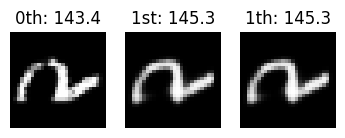

2, 187.54367065429688, 182.43212890625


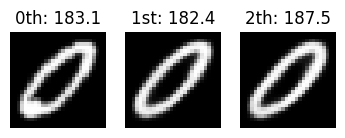

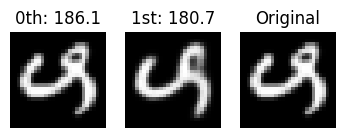

1, 199.75326538085938, 199.75326538085938


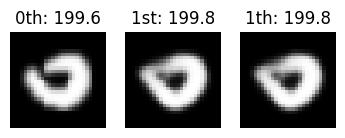

1, 177.65530395507812, 177.65530395507812


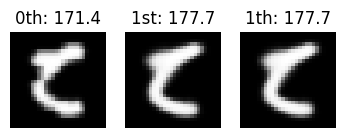

1, 176.1289825439453, 176.1289825439453


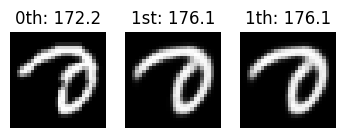

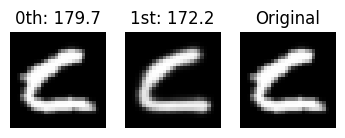

1, 169.93701171875, 169.93701171875


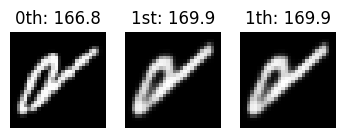

3, 171.8064727783203, 156.08779907226562


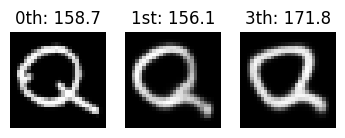

2, 129.14602661132812, 124.09182739257812


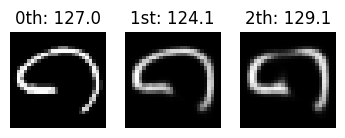

4, 162.46466064453125, 150.9722900390625


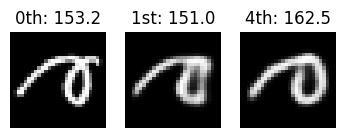

3, 166.79110717773438, 164.60079956054688


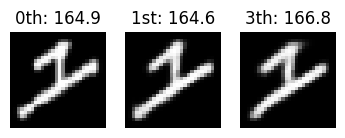

1, 105.98577880859375, 105.98577880859375


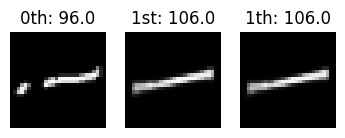

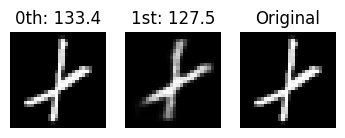

1, 159.16244506835938, 159.16244506835938


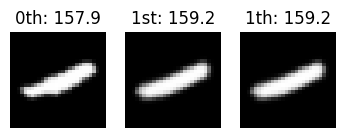

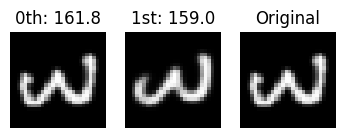

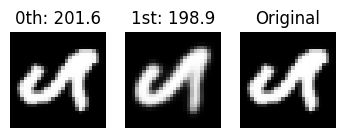

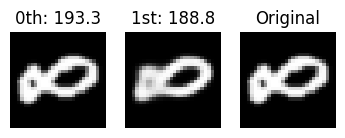

4, 174.35491943359375, 173.4779510498047


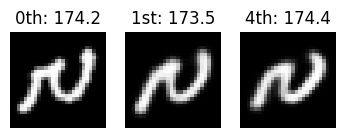

1, 169.81942749023438, 169.81942749023438


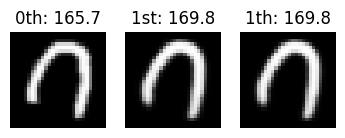

3, 166.92236328125, 160.64755249023438


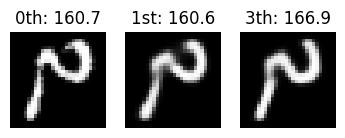

1, 166.41595458984375, 166.41595458984375


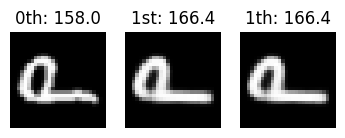

4, 162.94424438476562, 160.30172729492188


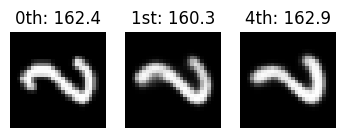

4, 188.03067016601562, 184.93006896972656


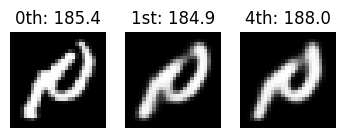

1, 188.5518798828125, 188.5518798828125


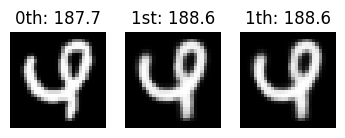

2, 166.00259399414062, 160.7317657470703


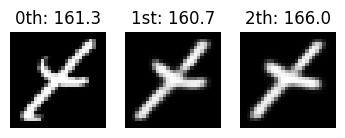

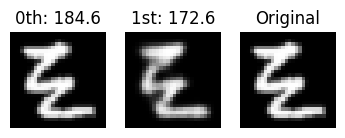

1, 165.3314971923828, 165.3314971923828


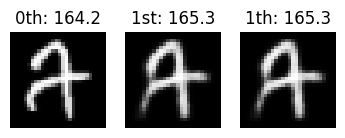

1, 172.1565704345703, 172.1565704345703


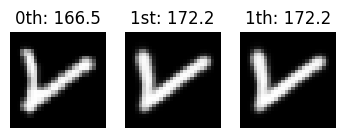

4, 151.03955078125, 142.83087158203125


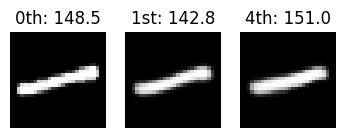

2, 206.87933349609375, 201.9480743408203


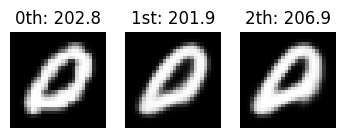

1, 183.76422119140625, 183.76422119140625


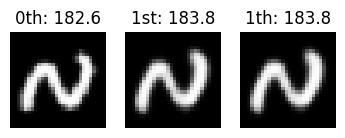

1, 162.79283142089844, 162.79283142089844


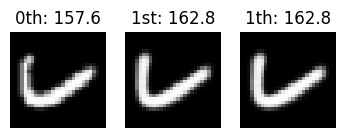

1, 143.24337768554688, 143.24337768554688


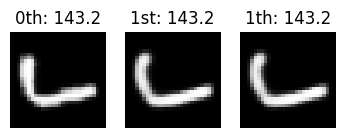

1, 165.0775146484375, 165.0775146484375


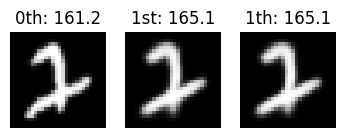

1, 196.68966674804688, 196.68966674804688


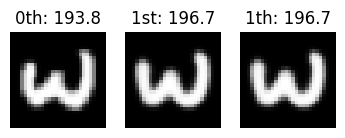

1, 196.42288208007812, 196.42288208007812


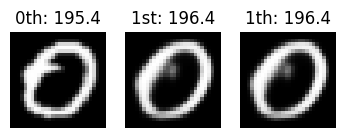

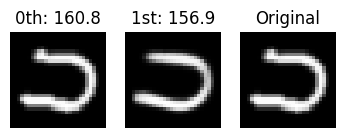

1, 202.25469970703125, 202.25469970703125


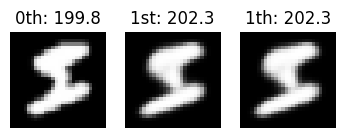

4, 178.43386840820312, 174.69769287109375


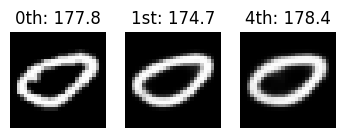

1, 196.07485961914062, 196.07485961914062


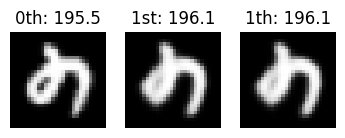

1, 149.5010986328125, 149.5010986328125


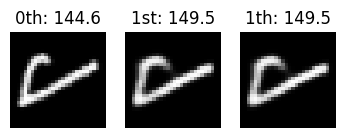

1, 192.11257934570312, 192.11257934570312


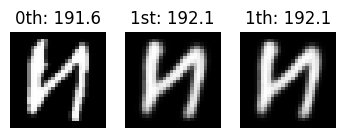

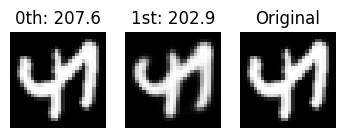

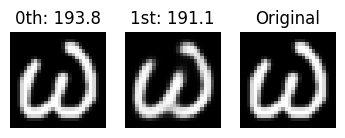

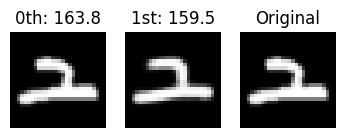

1, 165.79617309570312, 165.79617309570312


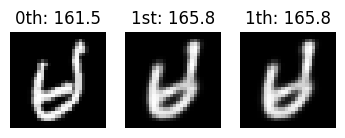

2, 192.32562255859375, 188.24729919433594


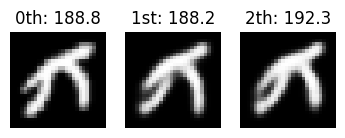

1, 179.88002014160156, 179.88002014160156


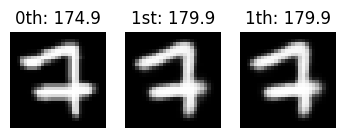

3, 178.8768310546875, 178.665771484375


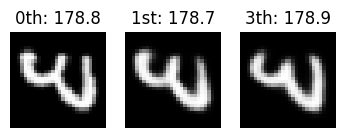

1, 172.00347900390625, 172.00347900390625


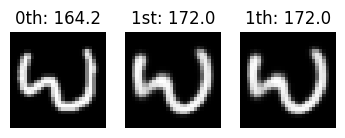

4, 160.77810668945312, 160.422119140625


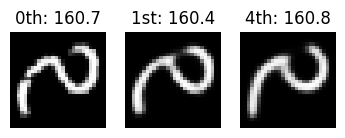

1, 158.93174743652344, 158.93174743652344


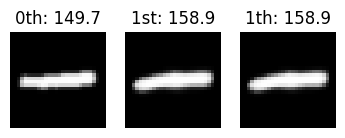

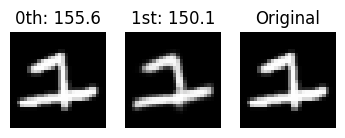

4, 156.86495971679688, 148.31051635742188


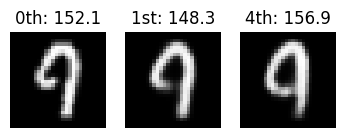

3, 168.82803344726562, 164.6508026123047


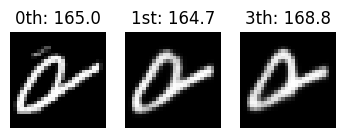

1, 181.5472412109375, 181.5472412109375


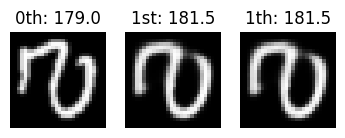

2, 203.82757568359375, 198.88856506347656


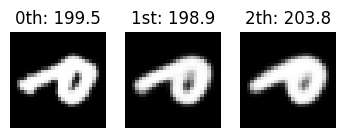

4, 213.4664306640625, 207.77574157714844


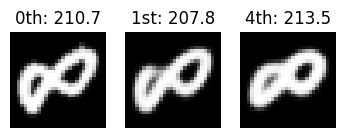

1, 139.86660766601562, 139.86660766601562


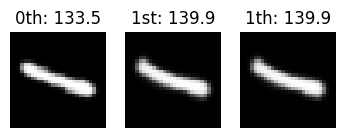

4, 147.526611328125, 141.16574096679688


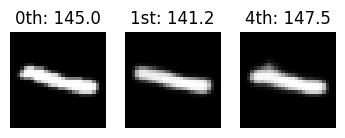

1, 147.399169921875, 147.399169921875


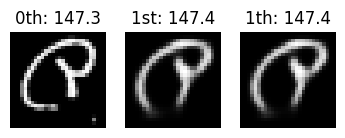

1, 189.06671142578125, 189.06671142578125


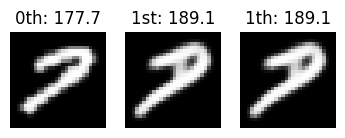

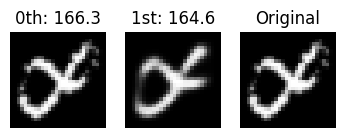

2, 175.782470703125, 171.5812530517578


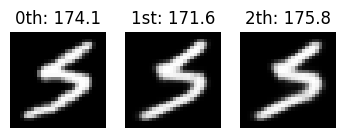

1, 113.67930603027344, 113.67930603027344


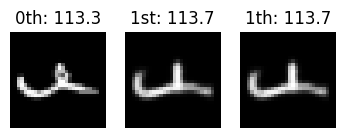

2, 150.42312622070312, 147.82342529296875


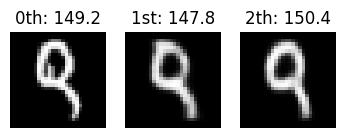

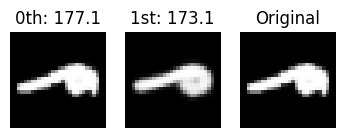

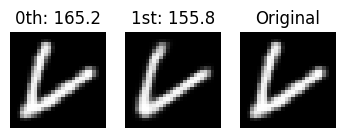

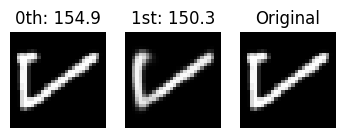

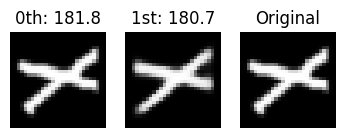

1, 154.88629150390625, 154.88629150390625


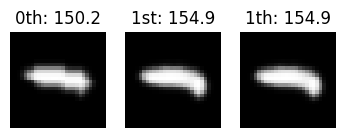

4, 155.7710723876953, 150.922119140625


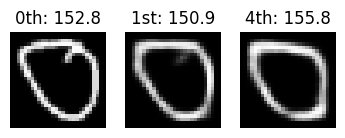

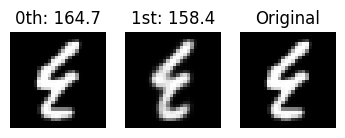

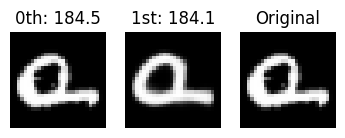

1, 169.64007568359375, 169.64007568359375


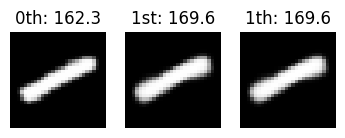

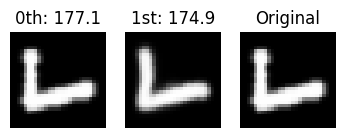

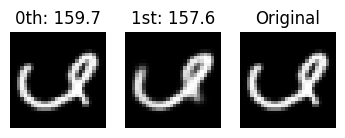

1, 134.03411865234375, 134.03411865234375


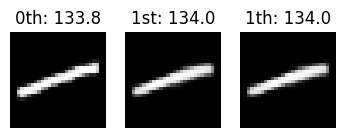

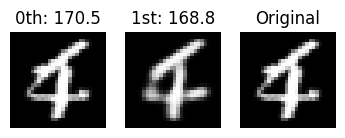

1, 199.40847778320312, 199.40847778320312


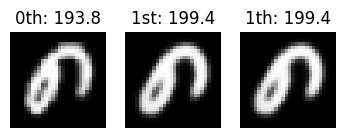

3, 141.3765106201172, 138.47869873046875


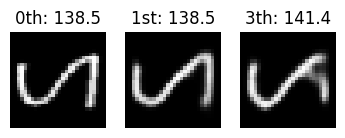

1, 155.02830505371094, 155.02830505371094


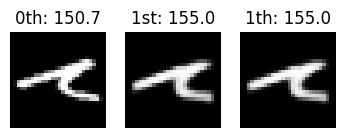

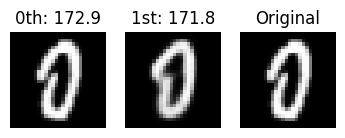

3, 133.5611572265625, 124.97126770019531


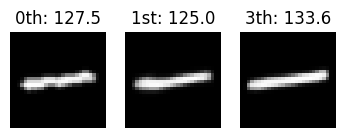

2, 158.85809326171875, 152.71493530273438


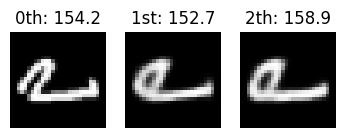

2, 208.642578125, 204.99920654296875


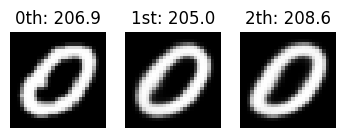

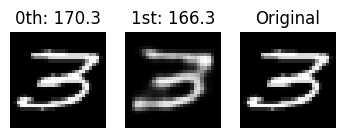

2, 182.192626953125, 179.069091796875


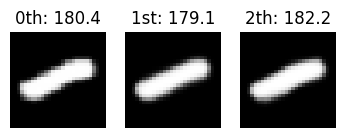

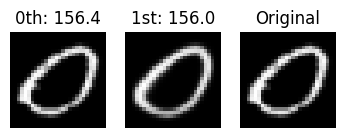

1, 176.26358032226562, 176.26358032226562


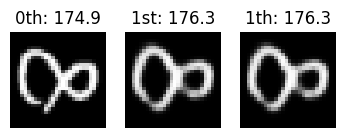

1, 160.1441192626953, 160.1441192626953


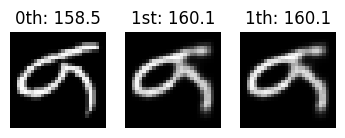

1, 199.8692169189453, 199.8692169189453


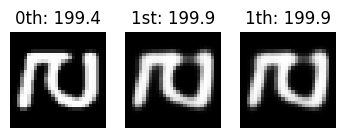

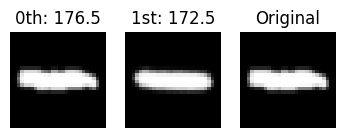

4, 189.27487182617188, 182.35093688964844


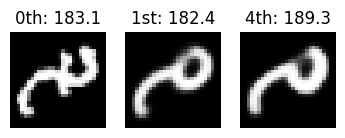

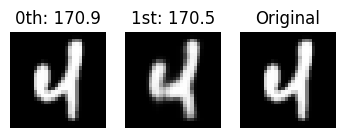

2, 216.71670532226562, 213.02059936523438


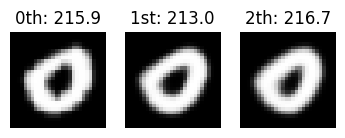

1, 183.54983520507812, 183.54983520507812


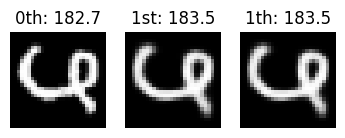

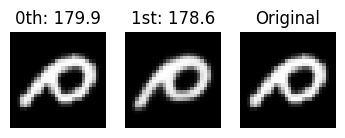

1, 192.2484588623047, 192.2484588623047


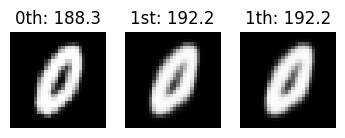

1, 155.19757080078125, 155.19757080078125


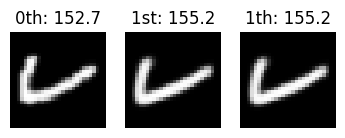

1, 225.53683471679688, 225.53683471679688


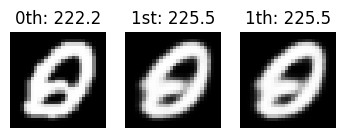

3, 153.06256103515625, 151.6402130126953


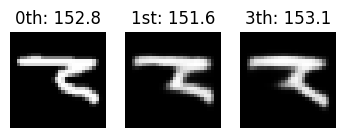

1, 143.23147583007812, 143.23147583007812


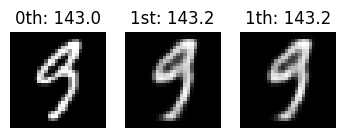

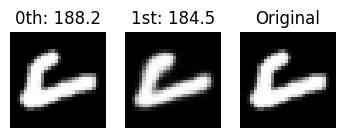

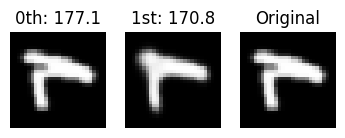

1, 134.3855743408203, 134.3855743408203


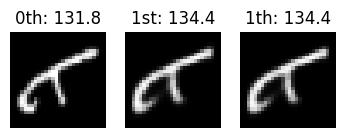

1, 164.722412109375, 164.722412109375


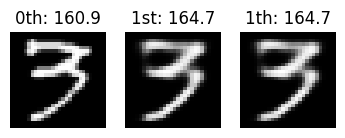

1, 147.0279541015625, 147.0279541015625


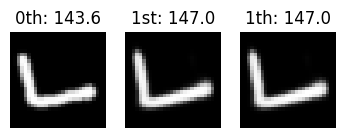

1, 131.072509765625, 131.072509765625


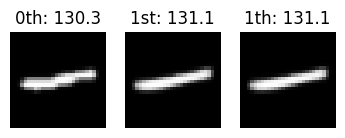

3, 154.21136474609375, 148.00506591796875


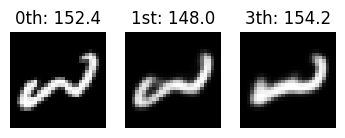

1, 145.25479125976562, 145.25479125976562


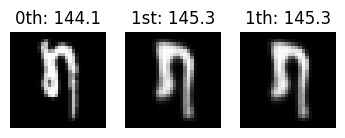

3, 199.64926147460938, 197.24688720703125


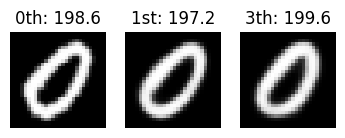

1, 153.94105529785156, 153.94105529785156


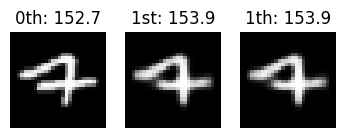

4, 136.7230987548828, 127.81807708740234


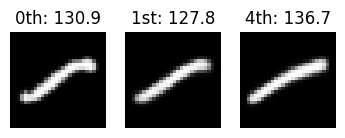

3, 166.34011840820312, 159.48501586914062


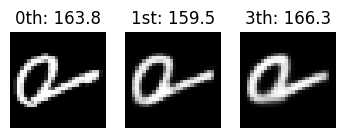

1, 179.34613037109375, 179.34613037109375


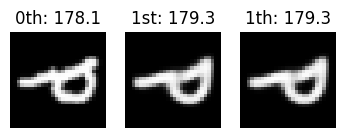

1, 175.29917907714844, 175.29917907714844


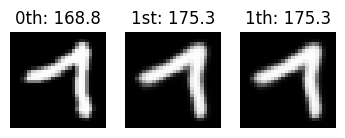

1, 179.91036987304688, 179.91036987304688


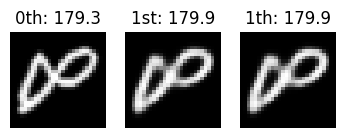

1, 166.9727783203125, 166.9727783203125


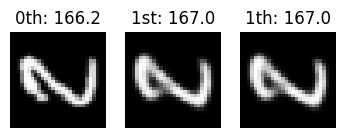

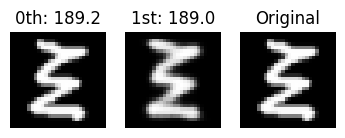

1, 202.73397827148438, 202.73397827148438


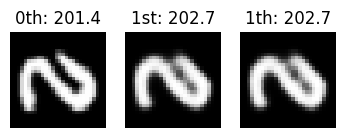

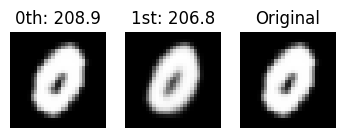

1, 130.91807556152344, 130.91807556152344


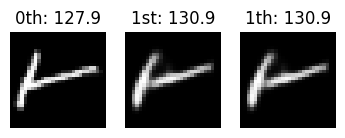

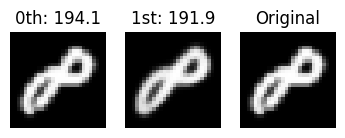

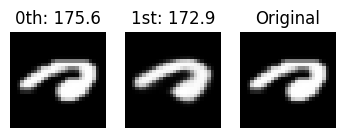

1, 165.75787353515625, 165.75787353515625


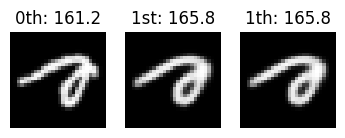

2, 199.25125122070312, 198.135986328125


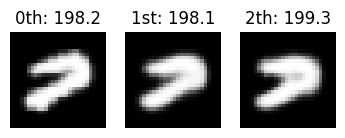

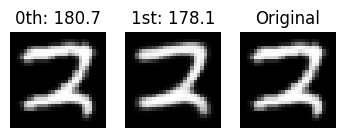

1, 166.57135009765625, 166.57135009765625


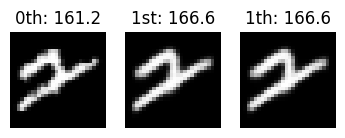

1, 156.32528686523438, 156.32528686523438


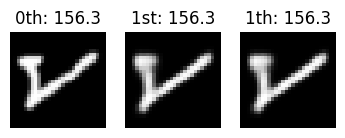

1, 120.84274291992188, 120.84274291992188


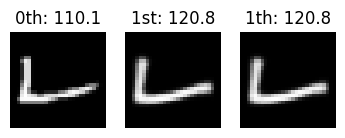

1, 149.34341430664062, 149.34341430664062


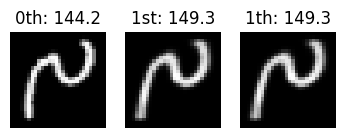

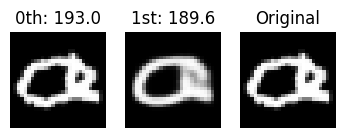

1, 147.25213623046875, 147.25213623046875


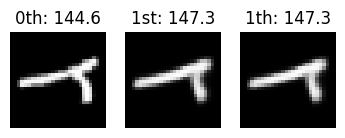

3, 142.92816162109375, 136.84945678710938


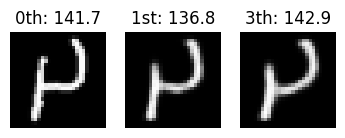

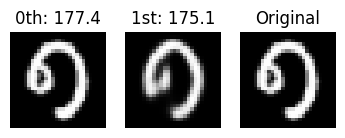

3, 174.2568359375, 171.53286743164062


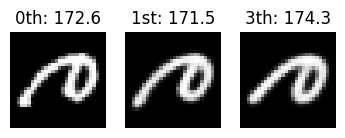

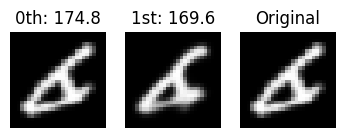

1, 160.61801147460938, 160.61801147460938


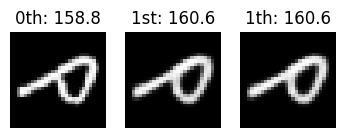

3, 149.4405517578125, 142.9617156982422


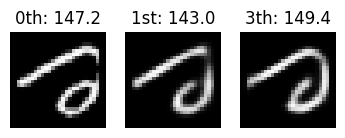

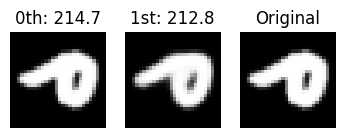

1, 138.86911010742188, 138.86911010742188


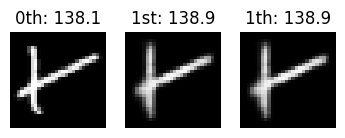

1, 179.76272583007812, 179.76272583007812


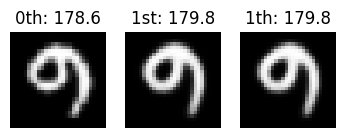

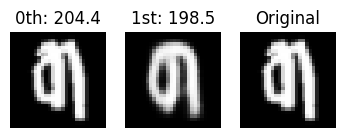

1, 140.8211669921875, 140.8211669921875


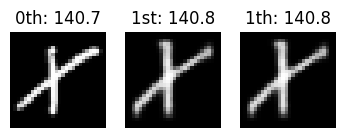

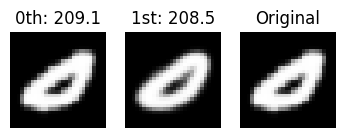

1, 186.31842041015625, 186.31842041015625


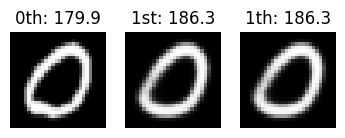

1, 166.9130096435547, 166.9130096435547


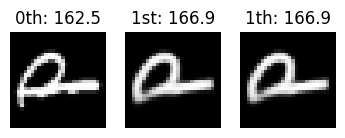

4, 169.34414672851562, 167.38970947265625


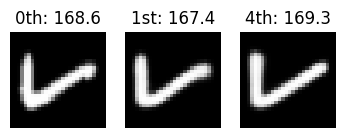

1, 147.48696899414062, 147.48696899414062


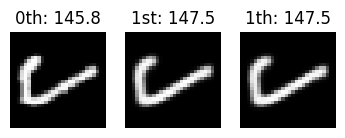

2, 174.8499755859375, 170.0357666015625


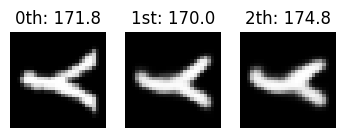

1, 196.80532836914062, 196.80532836914062


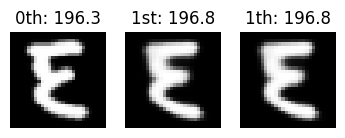

2, 188.18685913085938, 181.86959838867188


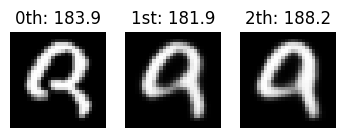

4, 108.56321716308594, 99.76322937011719


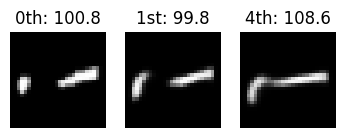

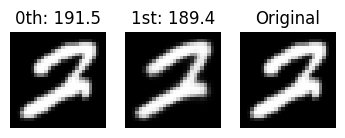

1, 213.43429565429688, 213.43429565429688


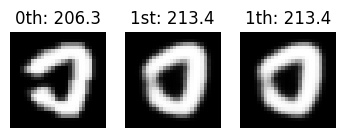

1, 131.42982482910156, 131.42982482910156


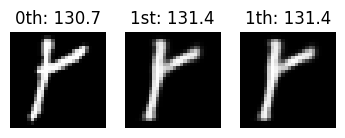

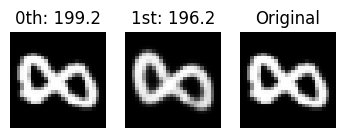

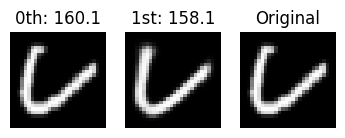

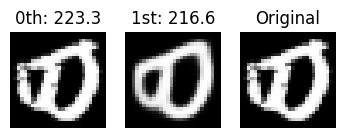

1, 196.1329345703125, 196.1329345703125


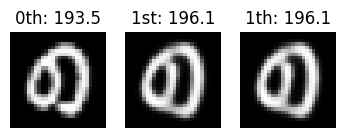

1, 186.66583251953125, 186.66583251953125


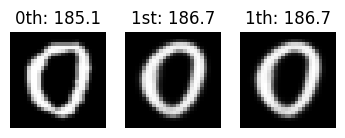

2, 191.4354248046875, 188.0589141845703


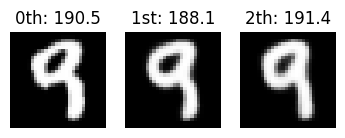

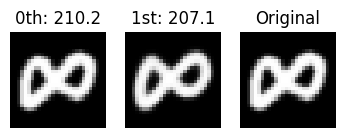

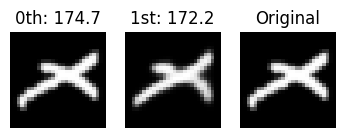

1, 203.17811584472656, 203.17811584472656


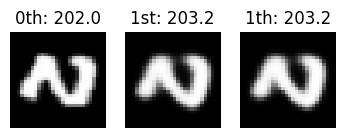

1, 155.13531494140625, 155.13531494140625


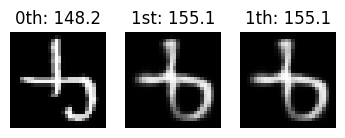

4, 187.77003479003906, 182.26559448242188


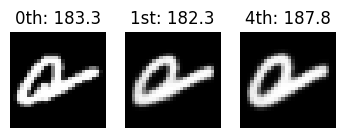

1, 187.08157348632812, 187.08157348632812


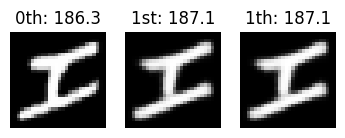

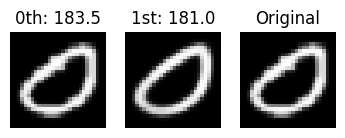

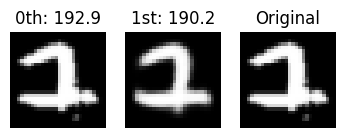

2, 183.4873046875, 182.4712371826172


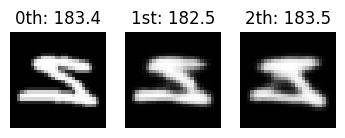

1, 175.75302124023438, 175.75302124023438


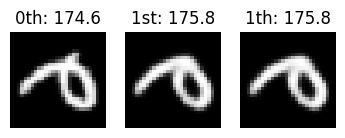

1, 195.12181091308594, 195.12181091308594


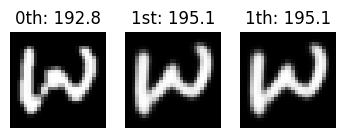

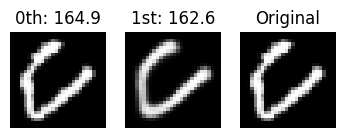

1, 157.81906127929688, 157.81906127929688


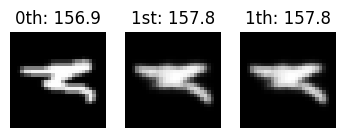

1, 137.55128479003906, 137.55128479003906


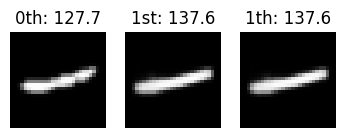

1, 176.49502563476562, 176.49502563476562


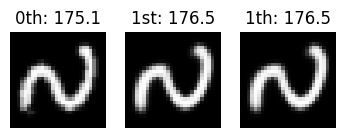

1, 176.72320556640625, 176.72320556640625


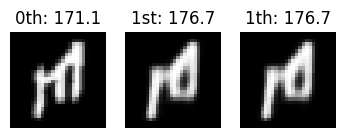

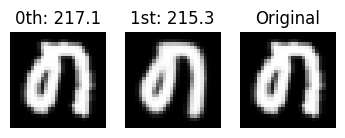

2, 131.38626098632812, 125.85882568359375


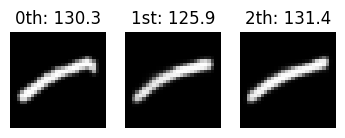

1, 180.15126037597656, 180.15126037597656


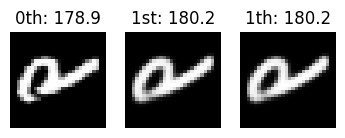

1, 192.88986206054688, 192.88986206054688


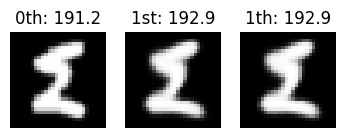

1, 177.30377197265625, 177.30377197265625


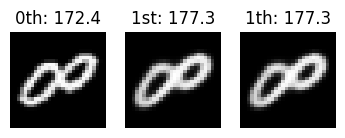

3, 178.65667724609375, 174.96286010742188


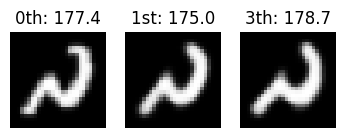

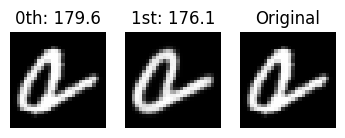

1, 156.7675018310547, 156.7675018310547


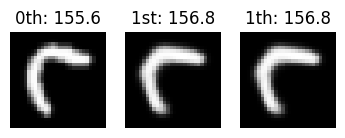

2, 195.08123779296875, 191.12435913085938


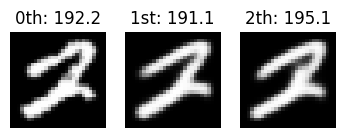

2, 171.1787872314453, 166.8829345703125


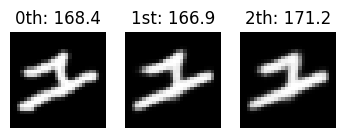

1, 129.59677124023438, 129.59677124023438


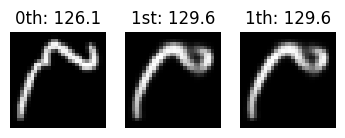

2, 167.36441040039062, 161.21646118164062


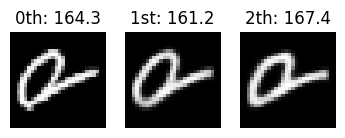

1, 173.35687255859375, 173.35687255859375


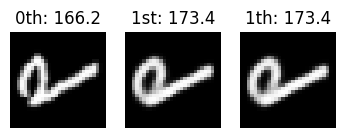

1, 151.28195190429688, 151.28195190429688


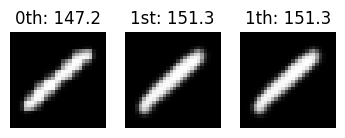

2, 195.4747314453125, 191.98538208007812


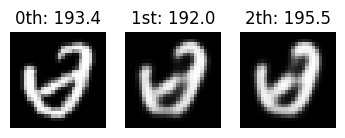

1, 147.43751525878906, 147.43751525878906


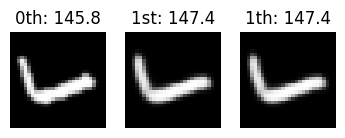

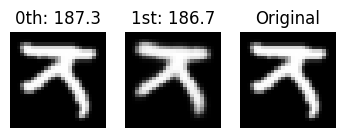

1, 201.8602294921875, 201.8602294921875


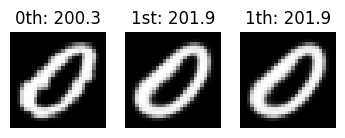

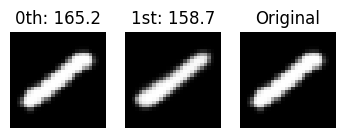

4, 183.3420867919922, 172.44656372070312


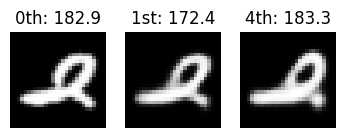

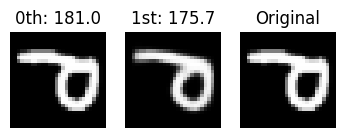

1, 203.76510620117188, 203.76510620117188


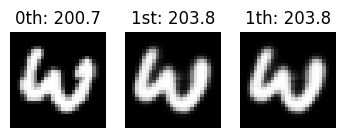

1, 199.6610107421875, 199.6610107421875


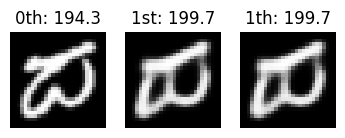

1, 151.4412078857422, 151.4412078857422


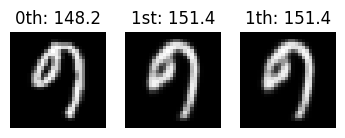

1, 173.93927001953125, 173.93927001953125


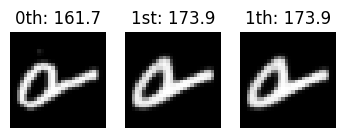

1, 171.37779235839844, 171.37779235839844


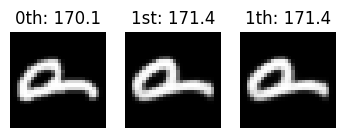

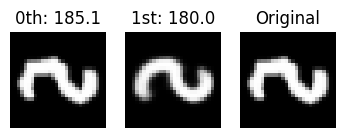

1, 198.60177612304688, 198.60177612304688


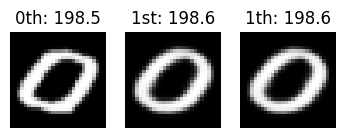

1, 178.181884765625, 178.181884765625


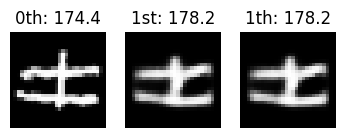

1, 185.69126892089844, 185.69126892089844


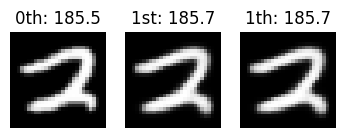

3, 166.976318359375, 164.20208740234375


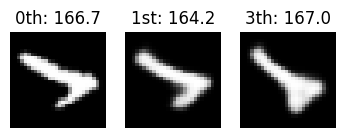

1, 169.05746459960938, 169.05746459960938


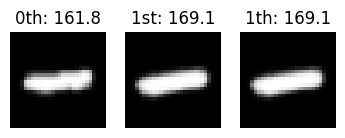

2, 170.6728515625, 164.85552978515625


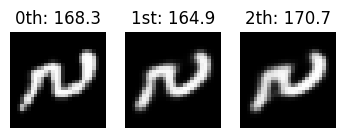

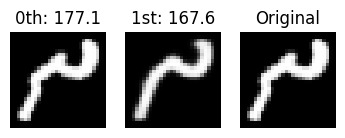

1, 175.54718017578125, 175.54718017578125


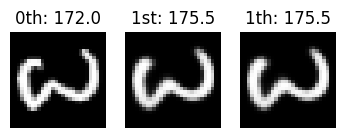

2, 192.9135284423828, 188.7744140625


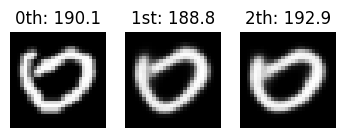

1, 173.91246032714844, 173.91246032714844


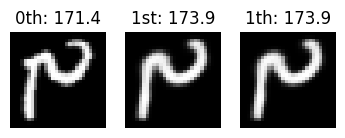

2, 193.167236328125, 187.94700622558594


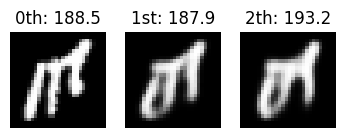

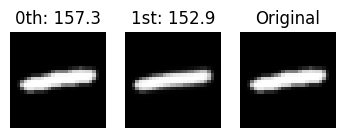

1, 190.49490356445312, 190.49490356445312


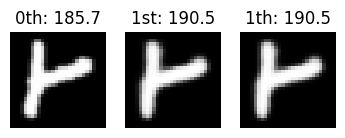

1, 179.35052490234375, 179.35052490234375


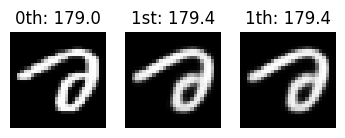

1, 191.48587036132812, 191.48587036132812


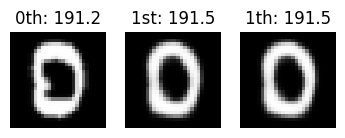

1, 148.67019653320312, 148.67019653320312


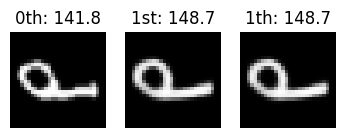

1, 191.94815063476562, 191.94815063476562


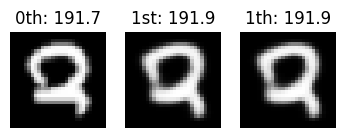

1, 144.6932830810547, 144.6932830810547


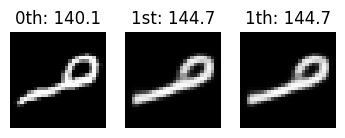

3, 167.83151245117188, 163.6247100830078


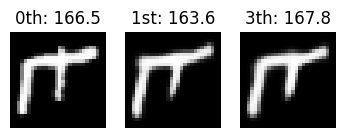

1, 164.0503692626953, 164.0503692626953


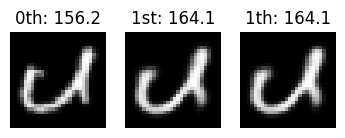

2, 139.8546142578125, 135.0988006591797


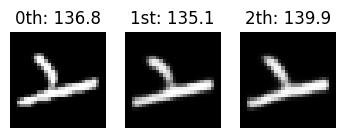

1, 169.92166137695312, 169.92166137695312


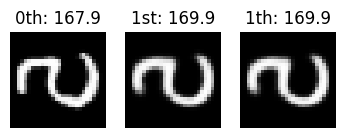

2, 116.11420440673828, 106.60262298583984


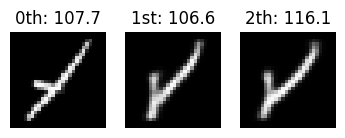

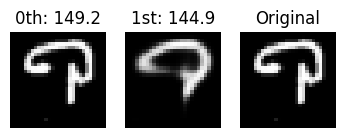

3, 163.45681762695312, 157.830322265625


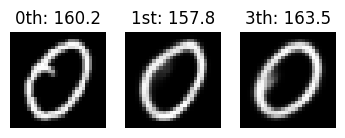

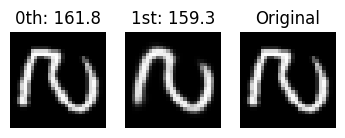

1, 199.70559692382812, 199.70559692382812


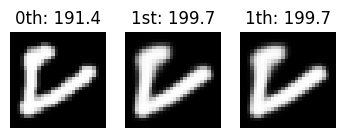

3, 203.00161743164062, 199.74270629882812


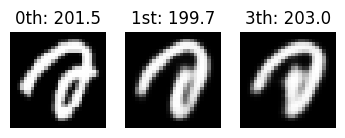

2, 182.45654296875, 176.2491455078125


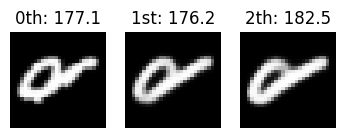

1, 160.97088623046875, 160.97088623046875


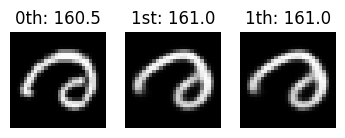

1, 183.41748046875, 183.41748046875


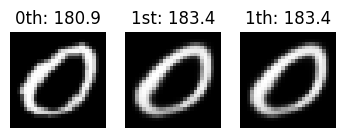

1, 184.94960021972656, 184.94960021972656


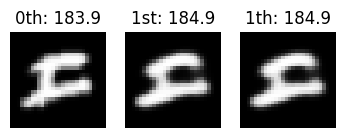

1, 170.77310180664062, 170.77310180664062


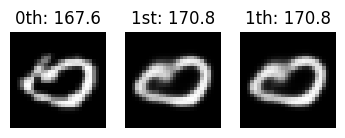

1, 184.87664794921875, 184.87664794921875


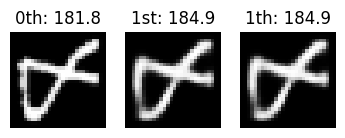

1, 205.7126922607422, 205.7126922607422


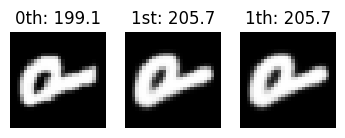

1, 217.33261108398438, 217.33261108398438


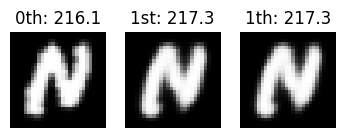

3, 188.2027587890625, 186.1577911376953


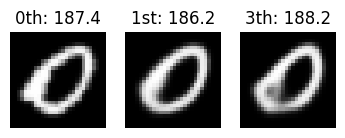

3, 151.77391052246094, 150.35076904296875


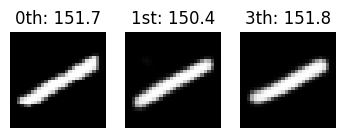

2, 206.72068786621094, 198.28167724609375


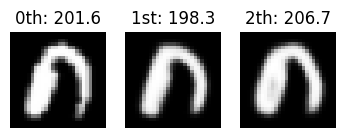

1, 174.12722778320312, 174.12722778320312


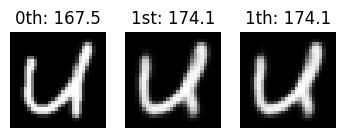

2, 96.80192565917969, 83.1571044921875


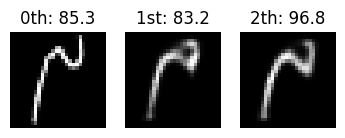

2, 163.5284423828125, 159.86135864257812


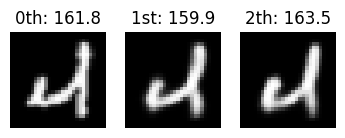

2, 183.29742431640625, 177.9541015625


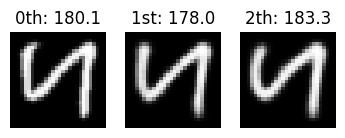

2, 200.85968017578125, 196.09939575195312


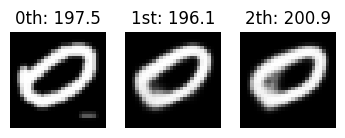

1, 154.77218627929688, 154.77218627929688


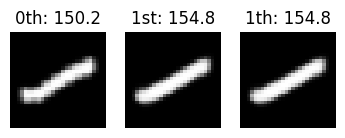

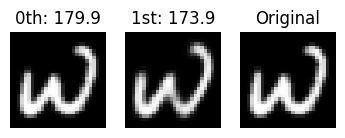

1, 181.08273315429688, 181.08273315429688


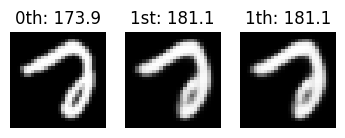

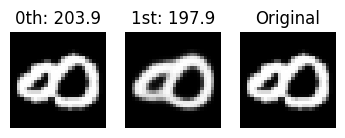

1, 170.12991333007812, 170.12991333007812


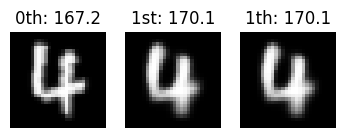

1, 139.8702392578125, 139.8702392578125


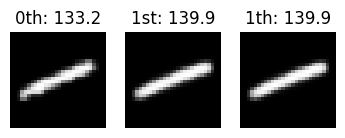

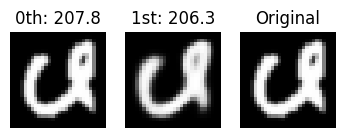

1, 139.15054321289062, 139.15054321289062


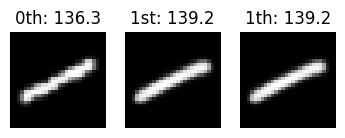

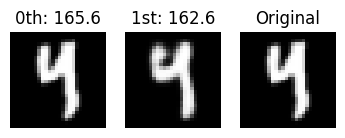

1, 157.54107666015625, 157.54107666015625


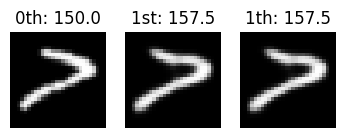

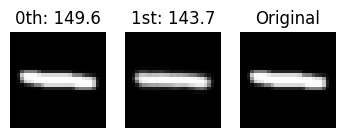

3, 194.25775146484375, 192.3248291015625


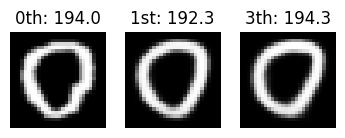

1, 190.7760772705078, 190.7760772705078


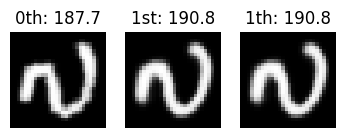

1, 190.59278869628906, 190.59278869628906


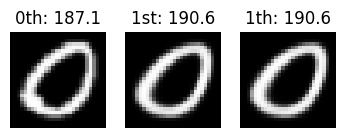

1, 182.15206909179688, 182.15206909179688


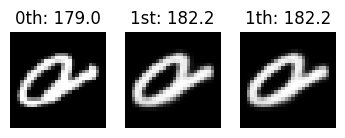

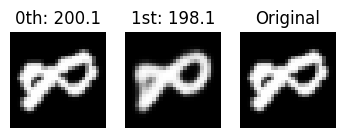

1, 179.55221557617188, 179.55221557617188


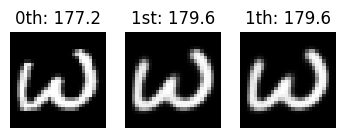

2, 151.00192260742188, 142.53909301757812


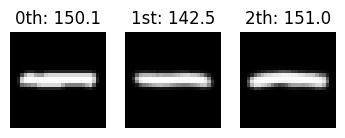

4, 186.72344970703125, 183.74481201171875


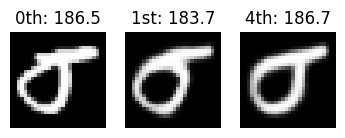

1, 175.10150146484375, 175.10150146484375


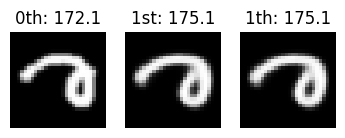

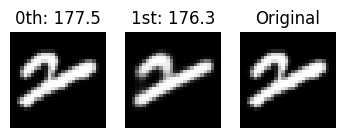

1, 159.354736328125, 159.354736328125


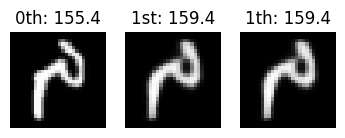

1, 180.03692626953125, 180.03692626953125


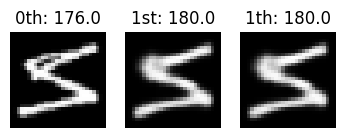

1, 190.36553955078125, 190.36553955078125


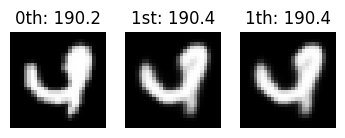

1, 166.251708984375, 166.251708984375


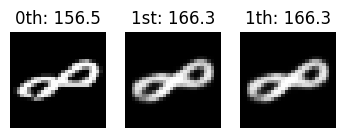

2, 205.84524536132812, 202.142822265625


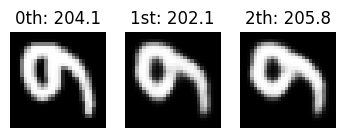

1, 189.97628784179688, 189.97628784179688


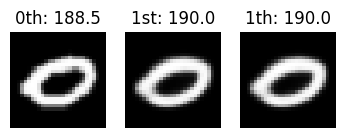

1, 164.59490966796875, 164.59490966796875


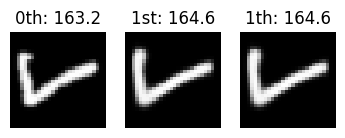

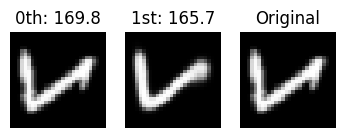

1, 204.8079833984375, 204.8079833984375


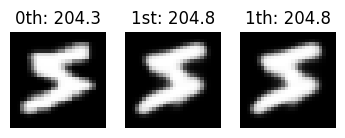

1, 143.40084838867188, 143.40084838867188


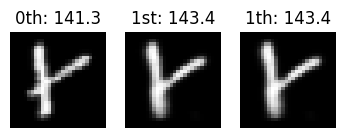

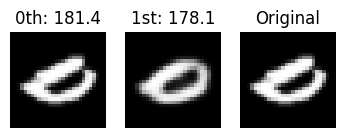

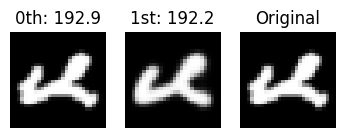

1, 177.7105255126953, 177.7105255126953


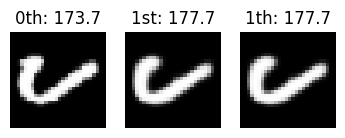

1, 186.54962158203125, 186.54962158203125


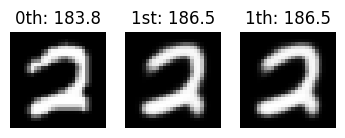

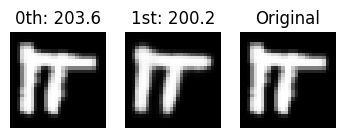

3, 204.5011444091797, 201.91067504882812


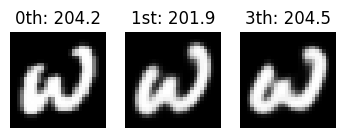

1, 166.67062377929688, 166.67062377929688


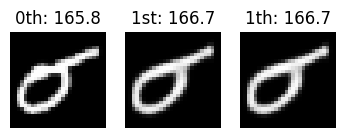

1, 173.87184143066406, 173.87184143066406


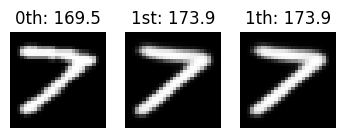

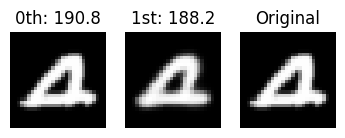

1, 195.11328125, 195.11328125


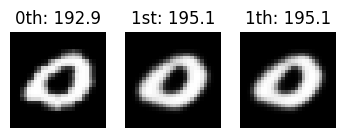

4, 148.6513671875, 147.27099609375


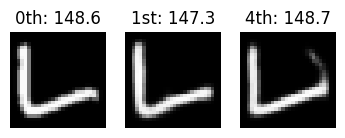

1, 193.46331787109375, 193.46331787109375


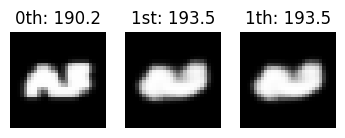

1, 163.77423095703125, 163.77423095703125


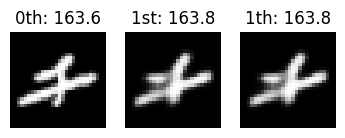

3, 208.3585205078125, 207.14892578125


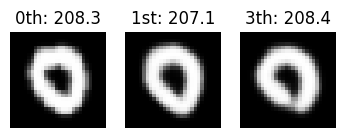

1, 143.04669189453125, 143.04669189453125


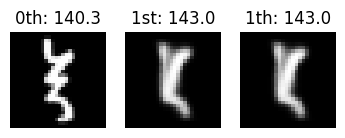

1, 184.18540954589844, 184.18540954589844


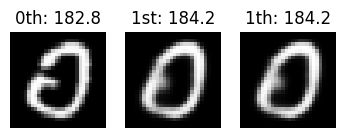

1, 153.53103637695312, 153.53103637695312


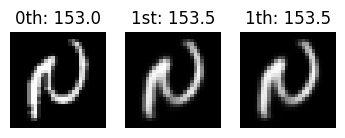

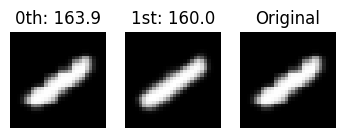

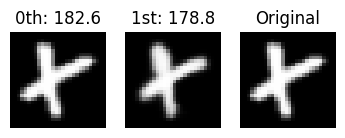

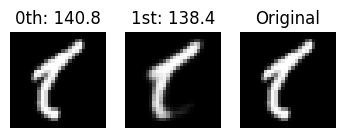

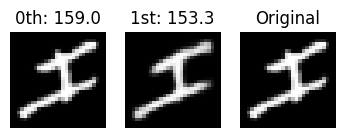

1, 137.00588989257812, 137.00588989257812


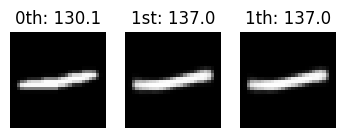

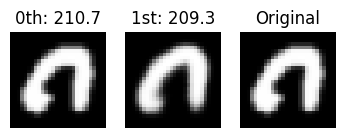

1, 156.80911254882812, 156.80911254882812


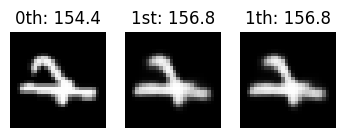

2, 175.1298828125, 164.55726623535156


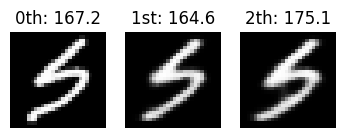

1, 158.02308654785156, 158.02308654785156


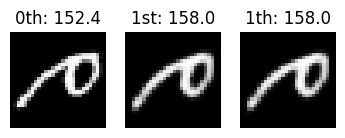

2, 157.2104034423828, 153.514892578125


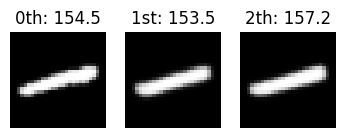

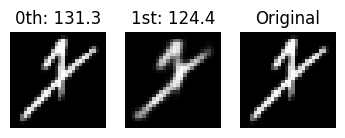

1, 160.81141662597656, 160.81141662597656


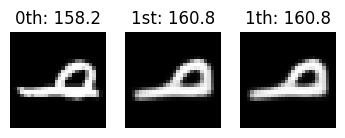

1, 199.67921447753906, 199.67921447753906


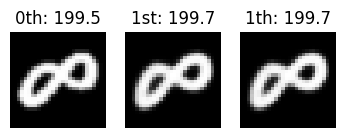

1, 115.65850830078125, 115.65850830078125


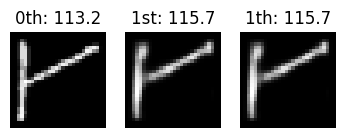

4, 161.85531616210938, 153.66567993164062


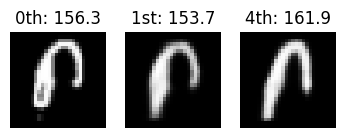

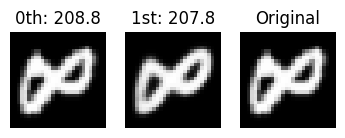

1, 156.6613006591797, 156.6613006591797


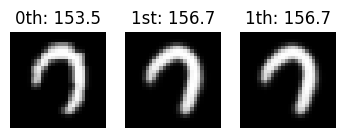

1, 160.6984405517578, 160.6984405517578


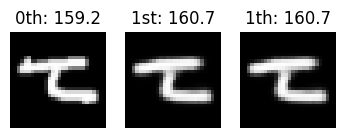

3, 188.9107666015625, 181.49807739257812


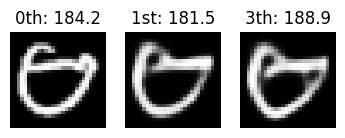

1, 140.82931518554688, 140.82931518554688


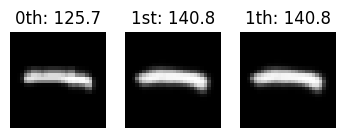

2, 161.26434326171875, 157.46554565429688


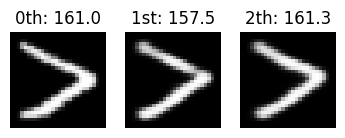

1, 217.4091796875, 217.4091796875


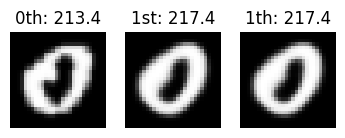

1, 190.46963500976562, 190.46963500976562


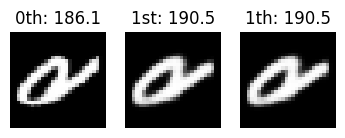

2, 132.86541748046875, 126.03736877441406


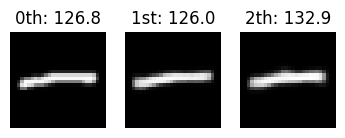

1, 144.16201782226562, 144.16201782226562


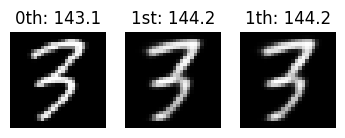

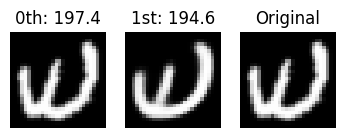

4, 154.90052795410156, 145.8211669921875


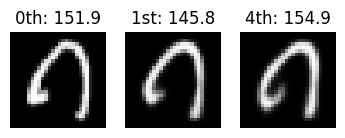

1, 181.8979034423828, 181.8979034423828


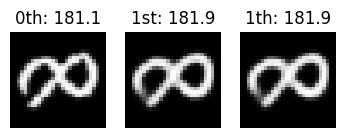

3, 157.14913940429688, 152.932861328125


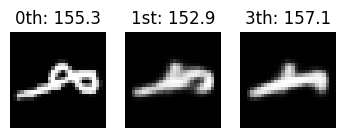

1, 152.88742065429688, 152.88742065429688


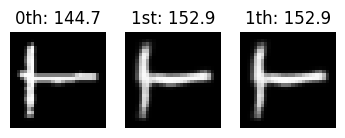

1, 174.00738525390625, 174.00738525390625


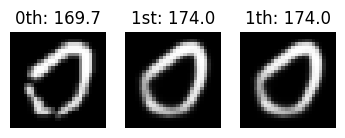

1, 116.2336654663086, 116.2336654663086


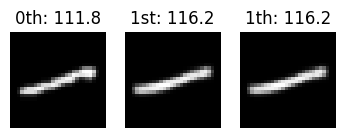

1, 185.13905334472656, 185.13905334472656


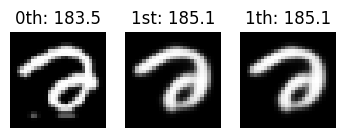

2, 217.2052001953125, 212.7415771484375


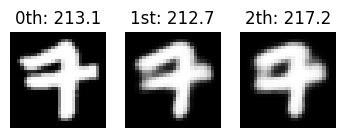

1, 156.707275390625, 156.707275390625


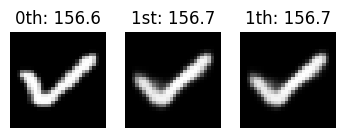

1, 169.250244140625, 169.250244140625


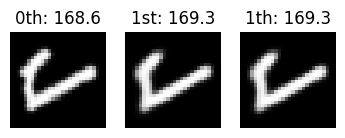

1, 184.34686279296875, 184.34686279296875


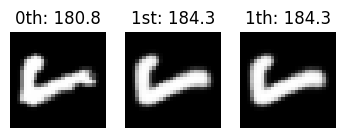

1, 192.88449096679688, 192.88449096679688


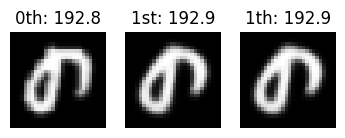

1, 187.9326171875, 187.9326171875


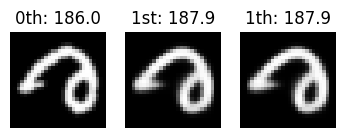

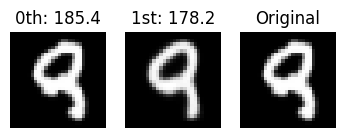

1, 187.3770751953125, 187.3770751953125


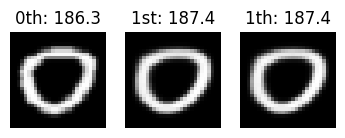

1, 164.40066528320312, 164.40066528320312


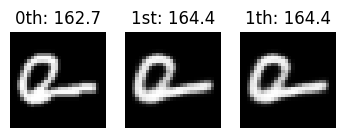

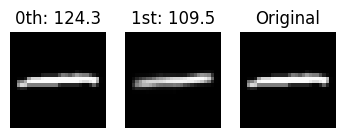

1, 140.08506774902344, 140.08506774902344


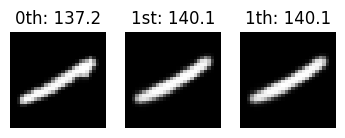

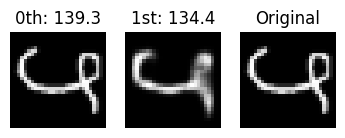

1, 183.93426513671875, 183.93426513671875


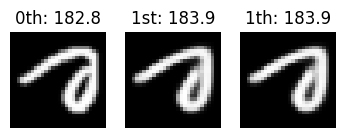

1, 124.45323181152344, 124.45323181152344


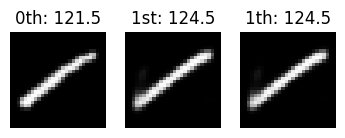

1, 213.19790649414062, 213.19790649414062


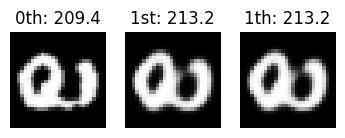

1, 151.79150390625, 151.79150390625


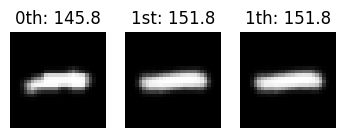

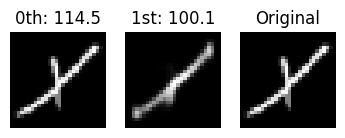

1, 191.897216796875, 191.897216796875


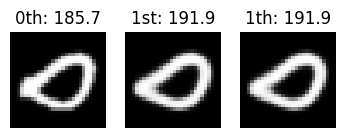

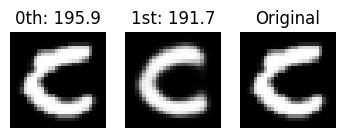

1, 200.17877197265625, 200.17877197265625


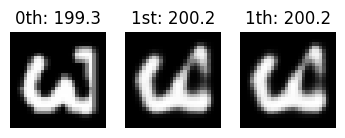

1, 139.83822631835938, 139.83822631835938


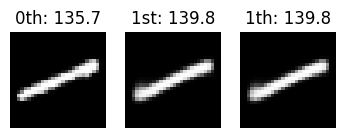

1, 156.24978637695312, 156.24978637695312


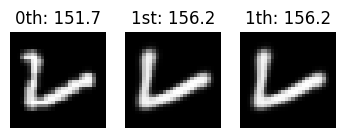

1, 169.88006591796875, 169.88006591796875


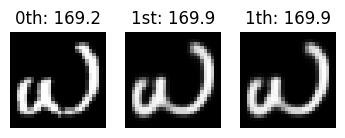

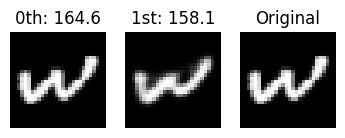

1, 147.08119201660156, 147.08119201660156


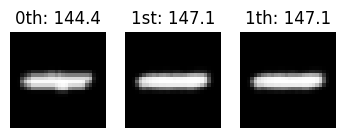

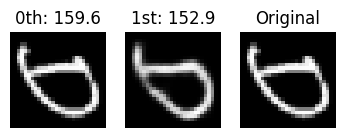

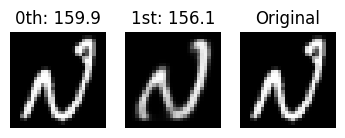

3, 142.1048583984375, 137.6090850830078


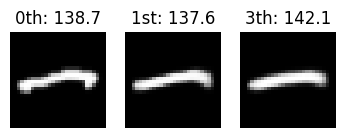

1, 212.26661682128906, 212.26661682128906


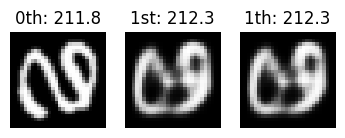

1, 148.00259399414062, 148.00259399414062


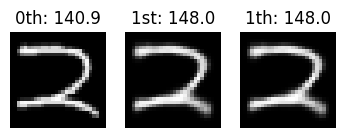

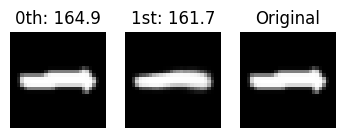

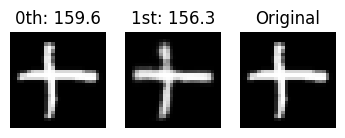

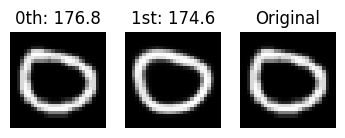

1, 138.51181030273438, 138.51181030273438


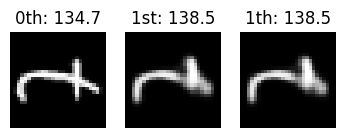

1, 142.62551879882812, 142.62551879882812


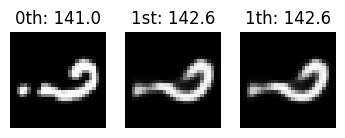

3, 199.37982177734375, 192.839111328125


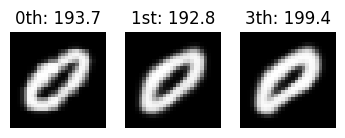

2, 183.31842041015625, 176.82406616210938


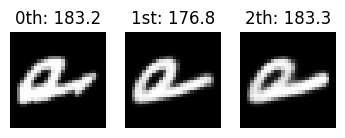

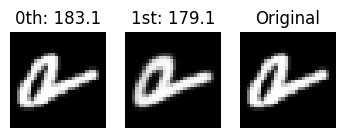

1, 176.63970947265625, 176.63970947265625


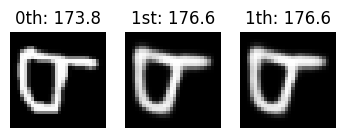

3, 141.53616333007812, 132.3372802734375


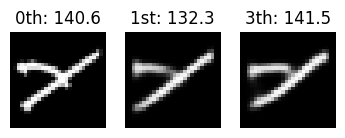

1, 149.09832763671875, 149.09832763671875


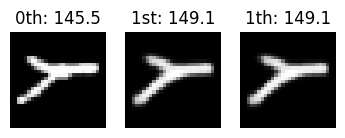

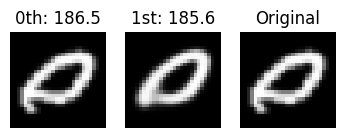

1, 172.07020568847656, 172.07020568847656


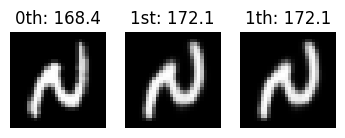

4, 191.11834716796875, 182.0763397216797


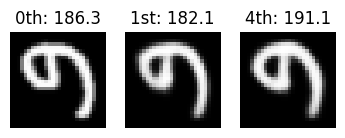

1, 192.7395477294922, 192.7395477294922


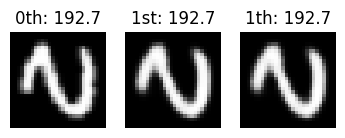

1, 163.469970703125, 163.469970703125


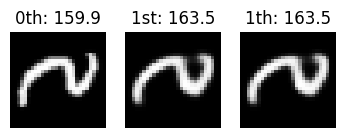

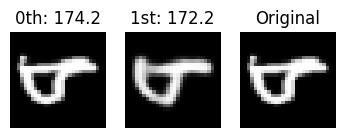

1, 175.72206115722656, 175.72206115722656


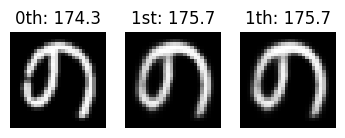

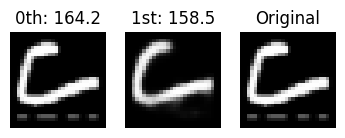

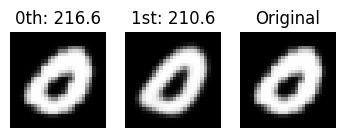

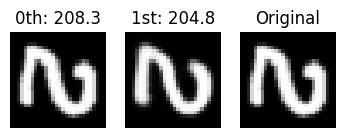

1, 174.45986938476562, 174.45986938476562


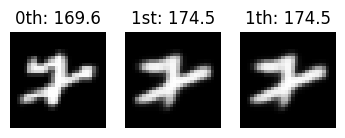

2, 186.90573120117188, 182.58213806152344


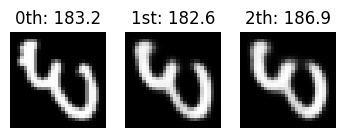

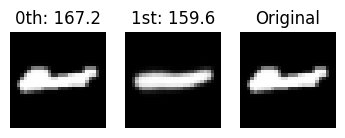

1, 178.31768798828125, 178.31768798828125


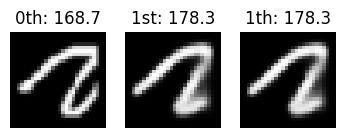

4, 185.81192016601562, 184.37168884277344


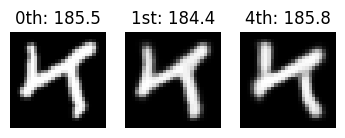

1, 165.41110229492188, 165.41110229492188


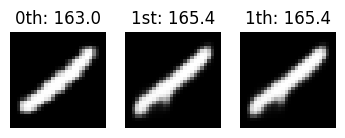

2, 194.761474609375, 190.19163513183594


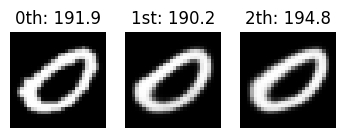

1, 148.45538330078125, 148.45538330078125


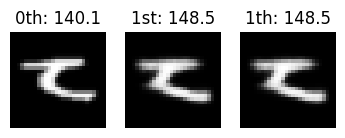

1, 172.20443725585938, 172.20443725585938


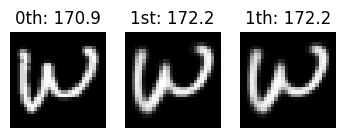

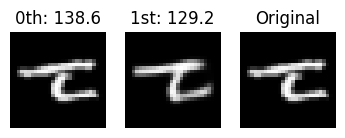

1, 186.01600646972656, 186.01600646972656


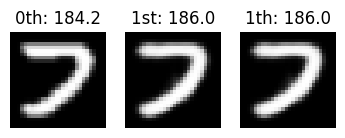

1, 174.12823486328125, 174.12823486328125


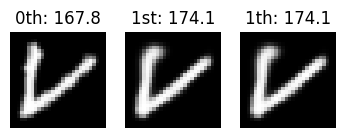

2, 200.42999267578125, 199.9932861328125


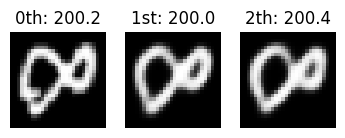

3, 171.98776245117188, 168.3066864013672


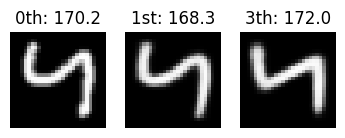

1, 176.99575805664062, 176.99575805664062


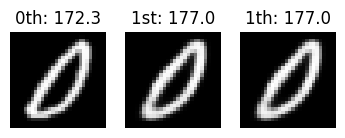

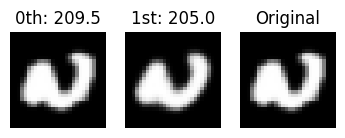

1, 213.5400390625, 213.5400390625


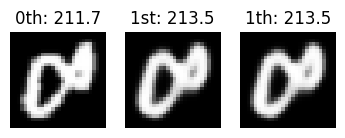

1, 152.00286865234375, 152.00286865234375


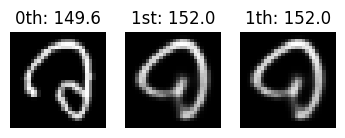

1, 171.7623748779297, 171.7623748779297


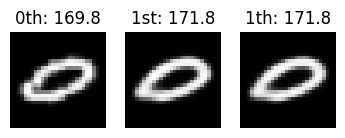

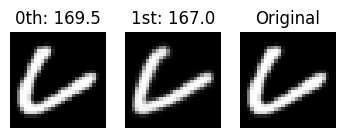

3, 166.3308563232422, 166.14059448242188


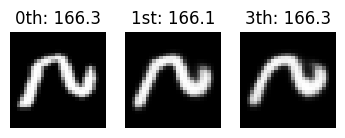

1, 176.26734924316406, 176.26734924316406


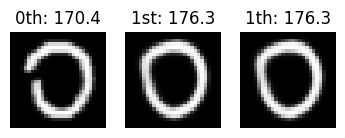

1, 197.72027587890625, 197.72027587890625


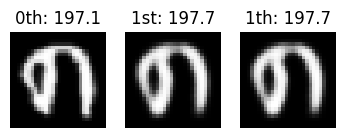

1, 150.3264923095703, 150.3264923095703


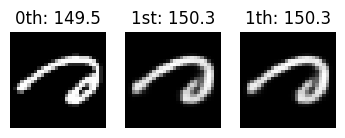

1, 126.8111801147461, 126.8111801147461


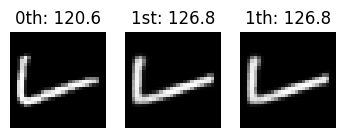

1, 163.31381225585938, 163.31381225585938


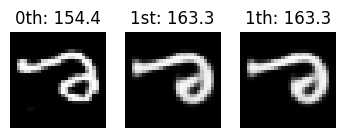

2, 197.02059936523438, 193.85275268554688


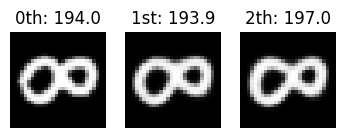

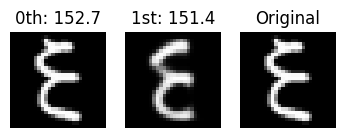

1, 164.59176635742188, 164.59176635742188


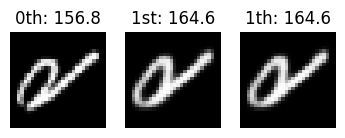

1, 134.04299926757812, 134.04299926757812


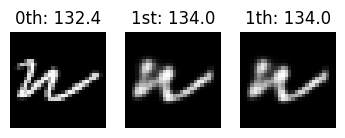

2, 199.435302734375, 196.93531799316406


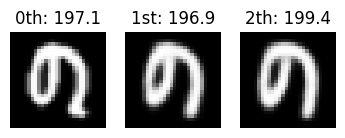

1, 194.13003540039062, 194.13003540039062


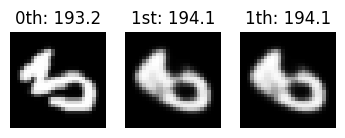

1, 169.6680908203125, 169.6680908203125


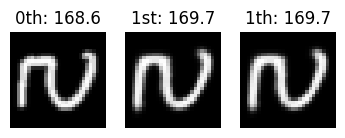

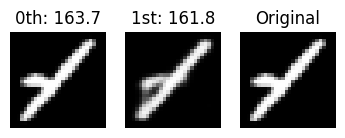

1, 167.51641845703125, 167.51641845703125


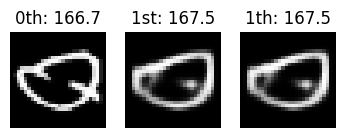

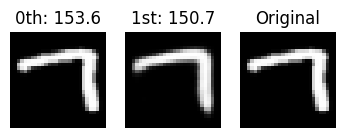

1, 172.84539794921875, 172.84539794921875


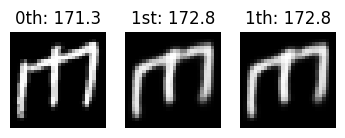

1, 162.48785400390625, 162.48785400390625


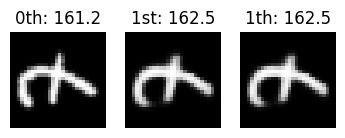

1, 181.64686584472656, 181.64686584472656


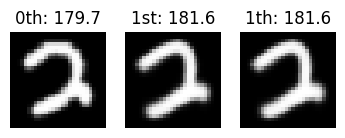

2, 189.70187377929688, 186.9049072265625


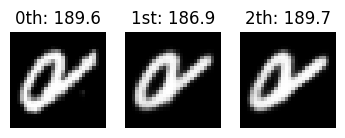

1, 198.0345458984375, 198.0345458984375


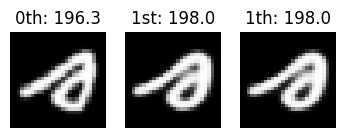

1, 155.06382751464844, 155.06382751464844


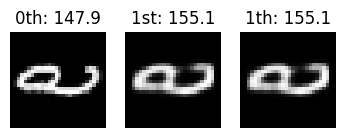

1, 164.36151123046875, 164.36151123046875


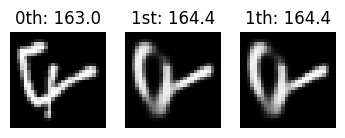

1, 194.06719970703125, 194.06719970703125


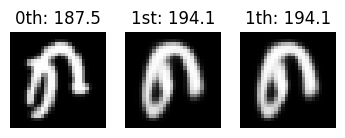

1, 166.16717529296875, 166.16717529296875


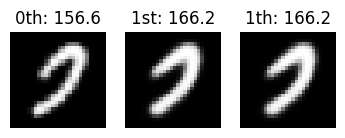

4, 194.2335205078125, 192.1533966064453


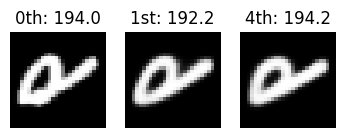

1, 190.85977172851562, 190.85977172851562


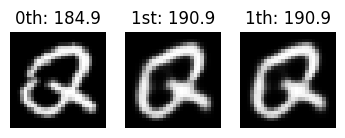

1, 186.31631469726562, 186.31631469726562


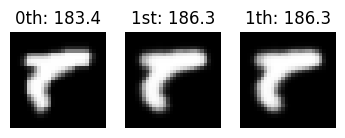

1, 168.11721801757812, 168.11721801757812


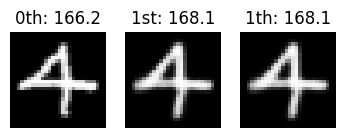

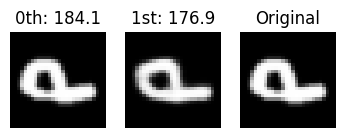

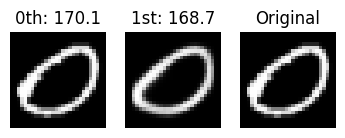

1, 136.79739379882812, 136.79739379882812


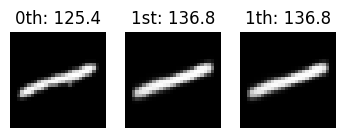

1, 181.1258544921875, 181.1258544921875


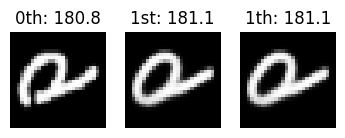

1, 175.1219482421875, 175.1219482421875


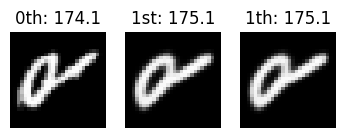

1, 126.64340209960938, 126.64340209960938


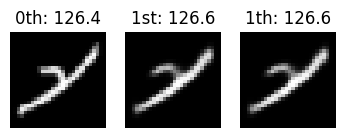

1, 166.39340209960938, 166.39340209960938


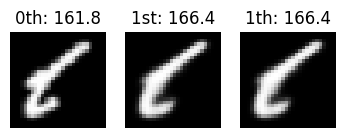

2, 174.71987915039062, 170.53472900390625


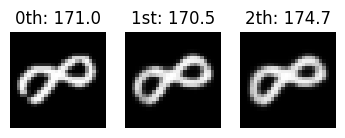

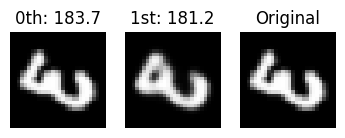

1, 139.8805389404297, 139.8805389404297


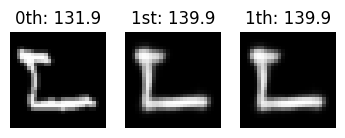

1, 218.06024169921875, 218.06024169921875


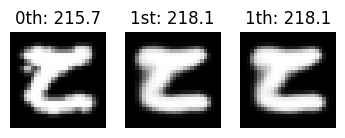

2, 203.92721557617188, 203.4434814453125


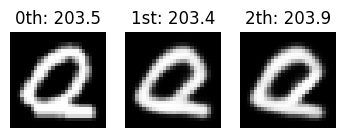

1, 152.17681884765625, 152.17681884765625


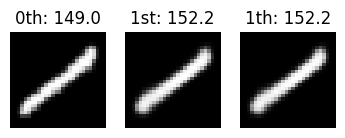

1, 185.8890380859375, 185.8890380859375


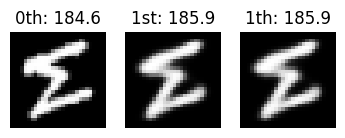

1, 140.75006103515625, 140.75006103515625


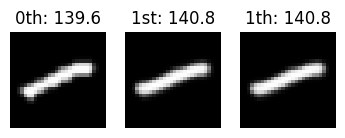

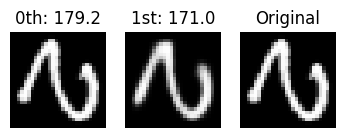

1, 124.5291748046875, 124.5291748046875


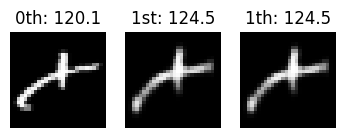

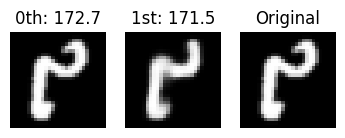

1, 163.73336791992188, 163.73336791992188


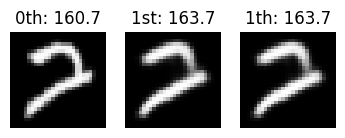

1, 164.42965698242188, 164.42965698242188


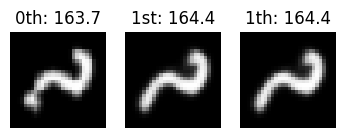

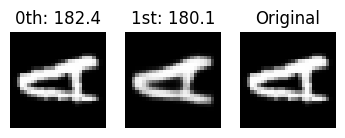

1, 208.42431640625, 208.42431640625


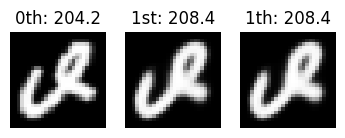

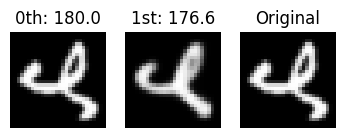

2, 172.68365478515625, 158.26043701171875


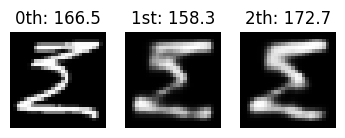

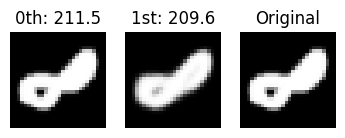

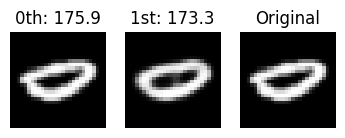

1, 208.9079132080078, 208.9079132080078


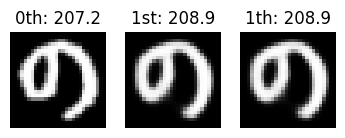

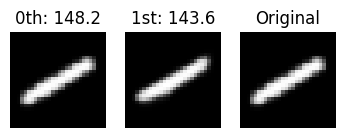

1, 165.02066040039062, 165.02066040039062


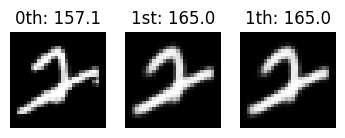

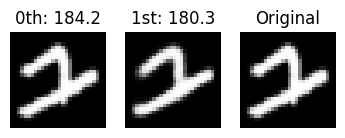

1, 165.21295166015625, 165.21295166015625


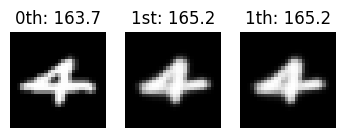

1, 179.7068634033203, 179.7068634033203


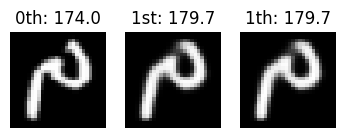

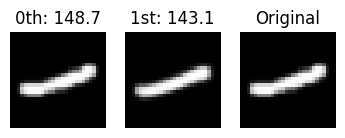

1, 226.66860961914062, 226.66860961914062


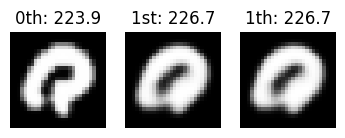

In [9]:
# Testing
data_loader = DataLoader(data_test, batch_size = 250, shuffle = True)
sampling = 5

for data, data_label in data_loader:
    fig, axes = plt.subplots(1, 3, figsize=(6*0.7, 2))
    image = data.to(device)
    values = evaluator(image.reshape(image.size(0),-1))[0]
    image_origin = image[0][0].cpu()
    value_origin = torch.log(values+1e-5).sum().item()
    axes[0].imshow(image_origin, cmap='gray')
    axes[0].set_title(f'0th: {value_origin:.1f}')
    axes[0].axis('off')  # Turn off axis numbers

    recon_x = image
    count = 0
    for i in range(1, sampling):
        recon_x, mean, log_var = model(recon_x)
        image = recon_x[0].detach()
        values = evaluator(image.reshape(image.size(0),-1))[0]
        value_image = torch.log(values+1e-5).sum().item()

        if i == 1:
            value = value_image
            axes[1].imshow(image[0].cpu(), cmap='gray')
            axes[1].set_title(f'1st: {value_image:.1f}')
            axes[1].axis('off')  # Turn off axis numbers

        if value_image >= value and value_image > value_origin:
            count += 1
            print(f"{i}, {value_image}, {value}")
            value = value_image
            axes[2].imshow(image[0].cpu(), cmap='gray')
            axes[2].set_title(f'{i}th: {value_image:.1f}')
            axes[2].axis('off')  # Turn off axis numbers
            if count == 1:
                break
    if count == 0:
        axes[2].imshow(image_origin, cmap='gray')
        axes[2].set_title(f'Original')
        axes[2].axis('off')  # Turn off axis numbers
    plt.show()
    plt.close()